In [1]:
#reward function: SOFA score measures patient health (higher score/increase in score should be penalised)
#referenced from: Deep Reinforcement Learning for Sepsis Treatment
def calculate_reward(cur_SOFA, next_SOFA, cur_MAP, next_MAP):
    reward = 0
    c0 = -0.025
    c1 = -0.125
    c2 = 0.4
    map_reward = 0
    if cur_SOFA == next_SOFA and next_SOFA > 0:
        reward += c0
    if cur_MAP == 3 and next_MAP == 3: #MAP stays at normal level
        map_reward = 0
    elif cur_MAP == next_MAP: #MAP stays at low level
        map_reward = (-3 + cur_MAP) * 0.5
    elif cur_MAP > next_MAP: #MAP deteriorates
        map_reward = (next_MAP - cur_MAP) * (4 - cur_MAP) * 0.8
    elif cur_MAP < next_MAP: #MAP improves
        map_reward = next_MAP - cur_MAP
    return reward + c1 * (next_SOFA - cur_SOFA) + c2 * map_reward

#calculate SOFA score for each state (using binned values)
def calculate_sofa_score(MAP, urine, ALT, AST, lactic_acid, serum_creatinine, p_f_ratio, GCS_total):
    cardiovascular_score = 0
    if MAP < 3:
        cardiovascular_score = 1
    
    respitory_score = 0
    if p_f_ratio == 0:
        respitory_score = 4
    elif p_f_ratio == 1:
        respitory_score = 3
    elif p_f_ratio == 2:
        respitory_score = 2
    else:
        respitory_score = 1
    
    renal_score = serum_creatinine

    #divide daily urine output standards by 6 as the data is 4 hour interval
    if urine == 1:
        renal_score = max(renal_score, 3)
    if urine == 0:
        renal_score = max(renal_score, 4)

    #since bilirubin is not available, use ALT and AST to calculate liver score
    liver_score = 0
    if (ALT > 0 and AST > 0):
        liver_score = 1
    if (ALT > 1 or AST > 1):
        liver_score = 2
    if (ALT > 2 or AST > 2):
        liver_score = 3

    neuro_score = 0
    if GCS_total == 0:
        neuro_score = 4
    elif GCS_total == 1:
        neuro_score = 3
    elif GCS_total  == 2:
        neuro_score = 2
    elif GCS_total == 3:
        neuro_score = 1
    
    lactic_acid_score = 0
    if lactic_acid > 0:
        lactic_acid_score = 2
    
    return cardiovascular_score + respitory_score + renal_score + liver_score + neuro_score + lactic_acid_score

In [2]:
#calculate transitions
import pandas as pd
import numpy as np

state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total']
action_columns = ['fluid_boluses', 'vasopressors']

def create_transitions(df):
    X = []
    y = []
    patients = df['PatientID'].unique()

    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1):
            current_state = patient_records.iloc[i][state_columns]
            next_state = patient_records.iloc[i + 1][state_columns]
            action = patient_records.iloc[i][action_columns]
            X.append(np.concatenate([current_state, action]))
            y.append(next_state)
    return pd.DataFrame(X, columns=state_columns + action_columns), pd.DataFrame(y, columns=state_columns)

df = pd.read_csv('binned_df.csv')

X, y = create_transitions(df)
print(X.head())
print(y.head())


   MAP  diastolic_bp  systolic_bp  urine  ALT  AST  lactic_acid  \
0    3             1            2      2    0    0            0   
1    2             1            2      2    0    0            0   
2    3             1            2      2    0    0            0   
3    0             1            1      2    0    0            0   
4    2             2            1      2    1    0            0   

   serum_creatinine  p_f_ratio  GCS_total  fluid_boluses  vasopressors  
0                 0          0          3              0             0  
1                 0          1          3              0             0  
2                 0          0          3              0             0  
3                 0          1          3              0             0  
4                 0          0          3              0             0  
   MAP  diastolic_bp  systolic_bp  urine  ALT  AST  lactic_acid  \
1    2             1            2      2    0    0            0   
2    3             1     

In [29]:
print(X.shape)
print(y.shape)

(183770, 12)
(183770, 10)


In [3]:
#use K nearest neighbours to calculate next state prediction (function approximation for transitions)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn_models = {col: KNeighborsClassifier(n_neighbors=20) for col in state_columns}

for col in state_columns:
    knn_models[col].fit(X_train, y_train[col])

#evaluate accuracy
predictions = pd.DataFrame()
for col in state_columns:
    predictions[col] = knn_models[col].predict(X_test)
    accuracy = accuracy_score(y_test[col], predictions[col])
    print(f"Accuracy for predicting {col}: {accuracy:.2f}")

Accuracy for predicting MAP: 0.50
Accuracy for predicting diastolic_bp: 0.69
Accuracy for predicting systolic_bp: 0.68
Accuracy for predicting urine: 0.71
Accuracy for predicting ALT: 0.81
Accuracy for predicting AST: 0.80
Accuracy for predicting lactic_acid: 0.93
Accuracy for predicting serum_creatinine: 0.85
Accuracy for predicting p_f_ratio: 0.63
Accuracy for predicting GCS_total: 0.89


In [4]:
#train test split
seed = 42
np.random.seed(seed)
train_ratio = 0.8
num_patients = df['PatientID'].nunique()
num_train_samples = int(num_patients * train_ratio)
train_ids = np.random.choice(num_patients, num_train_samples, replace=False)
train_df = df[df["PatientID"].isin(train_ids)].reset_index(drop=True)
test_df = df[~df["PatientID"].isin(train_ids)].reset_index(drop=True)
print(f'Train Data: {train_df.shape}')
print(f'Test Data: {test_df.shape}')

Train Data: (150144, 15)
Test Data: (37536, 15)


In [5]:
#helper functions
def return_state_action_df(row, fluid, vaso):
    state_action = {
        'MAP': row['MAP'].item(),
        'diastolic_bp': row['diastolic_bp'].item(),
        'systolic_bp': row['systolic_bp'].item(),
        'urine': row['urine'].item(),
        'ALT': row['ALT'].item(),
        'AST': row['AST'].item(),
        'lactic_acid': row['lactic_acid'].item(),
        'serum_creatinine': row['serum_creatinine'].item(),
        'p_f_ratio':row['p_f_ratio'].item(),
        'GCS_total': row['GCS_total'].item(),
        'fluid_boluses': fluid,
        'vasopressors': vaso
    }
    return pd.DataFrame([state_action])

def calc_sofa_score_from_row(row):
    return calculate_sofa_score(row['MAP'].item(), row['urine'].item(), row['ALT'].item(), row['AST'].item(), row['lactic_acid'].item(), row['serum_creatinine'].item(), row['p_f_ratio'].item(), row['GCS_total'].item())

In [6]:
def clinician_cumulative_reward(df):
    patients = df['PatientID'].unique()
    total_cumulative_reward = 0
    rewards = []
    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1):
            current_state = patient_records.iloc[i][state_columns]
            next_state = patient_records.iloc[i + 1][state_columns]
            #action = patient_records.iloc[i][action_columns]
            cur_sofa = calc_sofa_score_from_row(current_state)
            next_sofa = calc_sofa_score_from_row(next_state)
            reward = calculate_reward(cur_sofa, next_sofa, current_state['MAP'], next_state['MAP'])
            rewards.append(reward)
            total_cumulative_reward += reward
    return total_cumulative_reward, rewards

def no_action_cumulative_reward(df):
    patients = df['PatientID'].unique()
    total_cumulative_reward = 0
    rewards = []
    for patient in patients:
        #print(patient)
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        current_state = patient_records.iloc[0][state_columns]
        for i in range(len(patient_records) - 1):
            predicted_next_state = pd.DataFrame()
            for col in state_columns:
                predicted_next_state[col] = knn_models[col].predict(return_state_action_df(current_state, 0, 0))
            next_state = predicted_next_state
            cur_sofa = calc_sofa_score_from_row(current_state)
            next_sofa = calc_sofa_score_from_row(next_state)
            #print(type(current_state['MAP']))
            #print(type(next_state['MAP']))
            cur_map = current_state['MAP'] if isinstance(current_state['MAP'], (int, np.int64)) else current_state['MAP'].item()
            next_map = next_state['MAP'].item()
            #print(type(cur_map))
            #print(type(next_map))
            reward = calculate_reward(cur_sofa, next_sofa, cur_map, next_map)
            rewards.append(reward)
            total_cumulative_reward += reward
            current_state = next_state
    return total_cumulative_reward, rewards

In [7]:
small_test_df = test_df.head(48*7)

In [9]:
import matplotlib.pyplot as plt

total cumulative reward (clinician) per patient with SOFA score reward: -0.6802030051151065


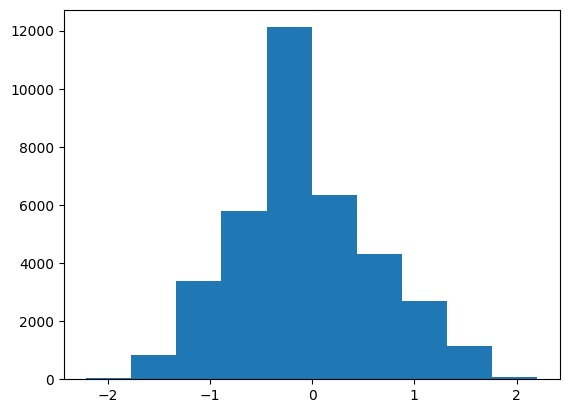

In [10]:
r1, rl1 = clinician_cumulative_reward(test_df)
print("total cumulative reward (clinician) per patient with SOFA score reward:", r1 / 3128)
plt.hist(rl1)
plt.show()


total cumulative reward (no action) per patient with SOFA score reward: -0.5631553708441757


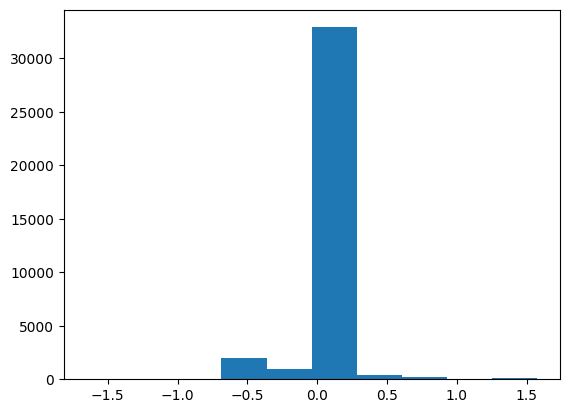

In [11]:
r2, rl2 = no_action_cumulative_reward(test_df)
print("total cumulative reward (no action) per patient with SOFA score reward:", r2 / 3128)
plt.hist(rl2)
plt.show()
#as there is not enough data on what will happen if no medication is given, the state transition prediction might not be accurate.

In [13]:
#define Dyna-Q agent
from collections import defaultdict
import random

class DynaQAgent:
    def __init__(self, state_size, action_size, gamma=0.9, alpha=0.1, epsilon=0.1, planning_steps=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.planning_steps = planning_steps
        self.q_table = np.zeros((state_size, action_size))
        self.model = defaultdict(lambda: (None, 0))  #(next_state, reward)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
        self.q_table[state, action] += self.alpha * (td_target - self.q_table[state, action])

        self.model[(state, action)] = (next_state, reward)

        for _ in range(self.planning_steps):
            sim_state, sim_action = random.choice(list(self.model.keys()))
            sim_next_state, sim_reward = self.model[(sim_state, sim_action)]

            sim_best_next_action = np.argmax(self.q_table[sim_next_state])
            sim_td_target = sim_reward + self.gamma * self.q_table[sim_next_state, sim_best_next_action]
            self.q_table[sim_state, sim_action] += self.alpha * (sim_td_target - self.q_table[sim_state, sim_action])


In [18]:
#Dyna-Q training
state_dict = {tuple(row): idx for idx, row in enumerate(df[state_columns].drop_duplicates().values)}
action_dict = {tuple(row): idx for idx, row in enumerate(df[action_columns].drop_duplicates().values)}
inverse_action_dict = {v: k for k, v in action_dict.items()}

def get_state_index(row):
    return state_dict[tuple(row[state_columns])]

def get_action_index(row):
    return action_dict[tuple(row[action_columns])]

def get_action_from_index(index):
    return inverse_action_dict[index]

def find_closest_index(input_tuple):
    closest_index = None
    min_distance = float('inf')
    
    for value, index in state_dict.items():
        distance = np.linalg.norm(np.array(value) - np.array(input_tuple))
        
        if distance < min_distance:
            min_distance = distance
            closest_index = index
    
    return closest_index

state_size = len(state_dict)
action_size = len(action_dict)
#print(state_size)
#print(action_size)

agent = DynaQAgent(state_size, action_size)

def train_dynaq(train_df):
    #i = 0
    for idx, row in train_df.iterrows():
        state = get_state_index(row)
        action = get_action_index(row)
        #if i % 1000 == 0:
            #print(i)
        #i += 1
        next_state_row = train_df[(train_df['PatientID'] == row['PatientID']) & (train_df['Timepoints'] == row['Timepoints'] + 1)]
        
        if not next_state_row.empty:
            next_row = next_state_row.iloc[0]
            next_state = get_state_index(next_row)
            reward = calculate_reward(calc_sofa_score_from_row(row), calc_sofa_score_from_row(next_row), row['MAP'], next_row['MAP'])
            agent.update(state, action, reward, next_state)
    return agent
            

In [19]:
print(state_dict)

{(3, 1, 2, 2, 0, 0, 0, 0, 0, 3): 0, (2, 1, 2, 2, 0, 0, 0, 0, 1, 3): 1, (0, 1, 1, 2, 0, 0, 0, 0, 1, 3): 2, (2, 2, 1, 2, 1, 0, 0, 0, 0, 3): 3, (2, 2, 2, 2, 0, 0, 0, 0, 1, 3): 4, (2, 1, 1, 2, 0, 0, 0, 1, 3, 3): 5, (0, 1, 1, 2, 0, 0, 0, 1, 3, 3): 6, (0, 1, 1, 2, 0, 0, 0, 1, 1, 3): 7, (3, 2, 2, 2, 0, 0, 0, 1, 3, 3): 8, (3, 1, 2, 2, 0, 0, 0, 1, 3, 3): 9, (3, 1, 1, 2, 0, 0, 0, 1, 1, 3): 10, (1, 1, 1, 2, 0, 0, 0, 1, 0, 3): 11, (3, 2, 2, 2, 0, 0, 0, 1, 1, 3): 12, (3, 1, 2, 2, 0, 0, 0, 1, 1, 3): 13, (0, 1, 1, 2, 1, 0, 0, 1, 0, 3): 14, (3, 2, 1, 2, 0, 0, 0, 1, 1, 3): 15, (2, 1, 1, 2, 0, 0, 0, 1, 0, 3): 16, (3, 2, 2, 2, 0, 0, 0, 1, 0, 3): 17, (2, 1, 2, 2, 0, 0, 0, 1, 1, 3): 18, (1, 1, 2, 1, 0, 0, 0, 0, 1, 3): 19, (0, 1, 1, 1, 0, 0, 0, 1, 2, 3): 20, (2, 1, 1, 1, 0, 0, 0, 1, 2, 3): 21, (3, 1, 2, 1, 0, 0, 0, 0, 1, 3): 22, (1, 1, 2, 1, 0, 0, 0, 0, 2, 3): 23, (3, 1, 2, 2, 0, 0, 0, 0, 3, 3): 24, (0, 1, 1, 2, 0, 0, 0, 1, 2, 0): 25, (3, 2, 2, 1, 0, 0, 0, 1, 2, 0): 26, (2, 1, 1, 1, 0, 0, 0, 1, 2, 0): 27, (

In [20]:
print(find_closest_index((3, 1, 2, 2, 0, 0, 0, 0, 0, 3)))

0


In [15]:
agent = train_dynaq(train_df)

In [16]:
#evaluate cumulative reward for Dyna-Q policy
def dynaq_cumulative_reward(df):
    patients = df['PatientID'].unique()
    total_cumulative_reward = 0
    rewards = []
    dynaq_map = []
    dynaq_fluids = []
    dynaq_vasopressors = []
    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        current_state = patient_records.iloc[0][state_columns]
        is_first = True
        for i in range(len(patient_records) - 1):
            state_tuple = tuple(current_state) if is_first else tuple(next_state.iloc[0].values)
            if state_tuple not in state_dict:
                state_idx = find_closest_index(state_tuple)
            else:
                state_idx = state_dict[state_tuple]
            action = agent.choose_action(state_idx)
            fluid = get_action_from_index(action)[0]
            vaso = get_action_from_index(action)[1]
            dynaq_fluids.append(fluid)
            dynaq_vasopressors.append(vaso)
            predicted_next_state = pd.DataFrame()
            for col in state_columns:
                predicted_next_state[col] = knn_models[col].predict(return_state_action_df(current_state, fluid, vaso))
            next_state = predicted_next_state
            cur_sofa = calc_sofa_score_from_row(current_state)
            next_sofa = calc_sofa_score_from_row(next_state)
            cur_map = current_state['MAP'] if isinstance(current_state['MAP'], (int, np.int64)) else current_state['MAP'].item()
            dynaq_map.append(cur_map)
            next_map = next_state['MAP'].item()
            reward = calculate_reward(cur_sofa, next_sofa, cur_map, next_map)
            total_cumulative_reward += reward
            rewards.append(reward)
            current_state = next_state
            is_first = False
    return total_cumulative_reward, rewards, dynaq_map, dynaq_fluids, dynaq_vasopressors


total cumulative reward (dyna Q) per patient with SOFA score reward: -0.29366048593335


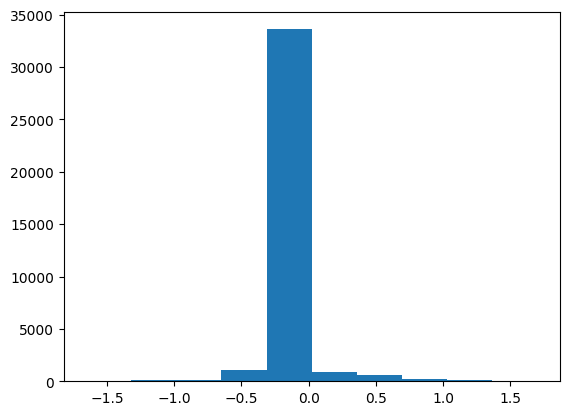

In [21]:
r3, rl3, dynaq_map, dynaq_fluids, dynaq_vasopressors = dynaq_cumulative_reward(test_df)
print("total cumulative reward (dyna Q) per patient with SOFA score reward:", r3 / 3128)
plt.hist(rl3)
plt.show()

In [46]:
#MAP vs action plot
import matplotlib.pyplot as plt
import seaborn as sns

#dynaq_map = [0,0,1,2,3]
#dynaq_fluids = [3,2,0,1,0]
#dynaq_vasopressors = [2,1,0,0,0]

policy_df = pd.DataFrame()
policy_df['MAP_tier'] = dynaq_map
policy_df['dynaq_fluid'] = dynaq_fluids
policy_df['dynaq_vasopressor'] = dynaq_vasopressors

dynaq_action_counts = policy_df.groupby(["MAP_tier", "dynaq_fluid", "dynaq_vasopressor"]).size().reset_index(name="dynaq_count")

def get_action_proportion(action_count_df, policy, action_name):
    counts = action_count_df.groupby(["MAP_tier", f"{policy}_{action_name}"])[f"{policy}_count"].sum()
    #print(counts)
    proportions = counts.groupby(level=0, group_keys=False).apply(lambda x: x / x.sum()).reset_index(name='proportion')
    
    proportions = proportions.rename(columns={f"{policy}_{action_name}": action_name})
    #print(proportions)
    return proportions

<Axes: xlabel='MAP_tier', ylabel='proportion'>

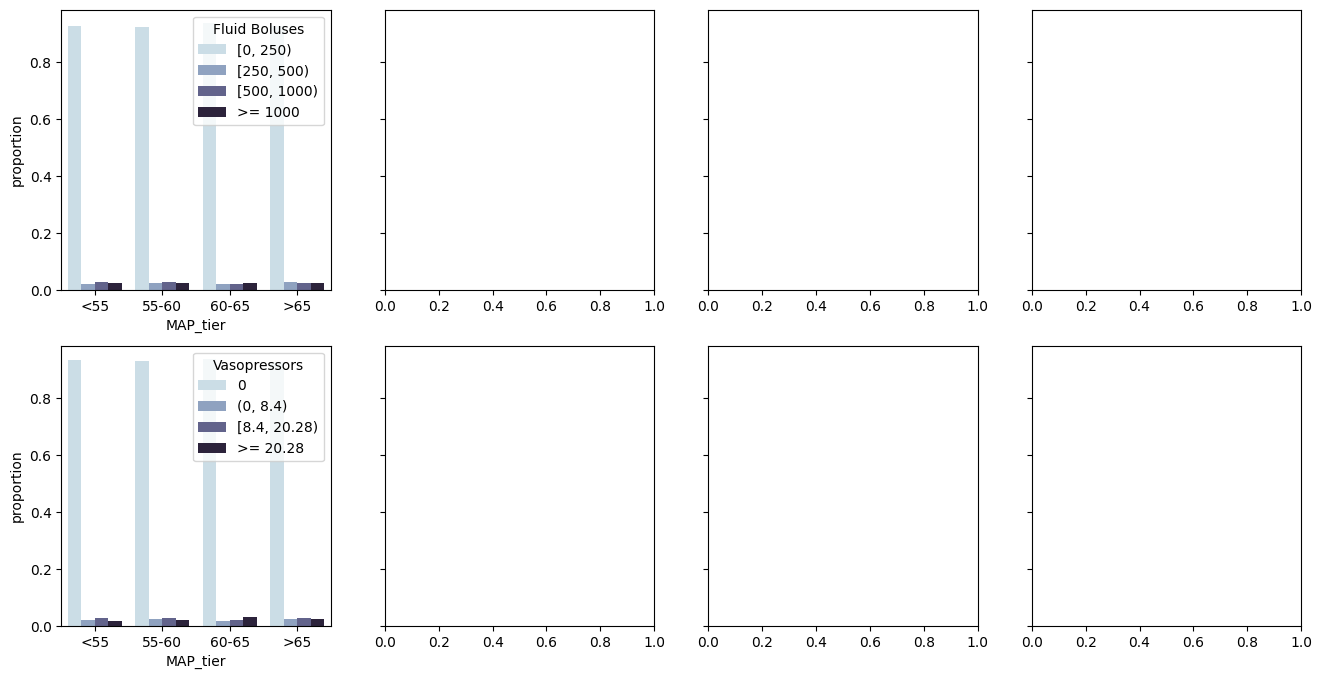

In [44]:
dynaq_fluid_proportions = get_action_proportion(dynaq_action_counts, "dynaq", "fluid")
dynaq_vaso_proportions = get_action_proportion(dynaq_action_counts, "dynaq", "vasopressor")
#map MAP and actions from 0,1,2,3 to text
fluid_bolus_order = {0: "[0, 250)", 1: "[250, 500)", 2: "[500, 1000)", 3: ">= 1000"}
vasopressor_order = {0: "0", 1: "(0, 8.4)", 2: "[8.4, 20.28)", 3: ">= 20.28"}
map_tier_order = bl = {0: "<55", 1: "55-60", 2: "60-65", 3: ">65"}
dynaq_fluid_proportions['Fluid Boluses'] = dynaq_fluid_proportions['fluid'].map(fluid_bolus_order)
dynaq_fluid_proportions['MAP_tier'] = dynaq_fluid_proportions['MAP_tier'].map(map_tier_order)
dynaq_vaso_proportions['Vasopressors'] = dynaq_vaso_proportions['vasopressor'].map(vasopressor_order)
dynaq_vaso_proportions['MAP_tier'] = dynaq_vaso_proportions['MAP_tier'].map(map_tier_order)
dynaq_fluid_proportions.drop('fluid', axis='columns', inplace=True)
dynaq_vaso_proportions.drop('vasopressor', axis='columns', inplace=True)

#print(dynaq_fluid_proportions)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey='row')
sns.barplot(data=dynaq_fluid_proportions, x='MAP_tier', y='proportion', hue='Fluid Boluses', 
            palette="ch:s=.25,rot=-.25", ax=axes[0, 0])
sns.barplot(data=dynaq_vaso_proportions, x='MAP_tier', y='proportion', hue='Vasopressors', 
                palette="ch:s=.25,rot=-.25", ax=axes[1, 0])


In [48]:
dynaq_fluid_proportions.to_csv('dynaq_fluid_proportions.csv')
dynaq_vaso_proportions.to_csv('dynaq_vaso_proportions.csv')

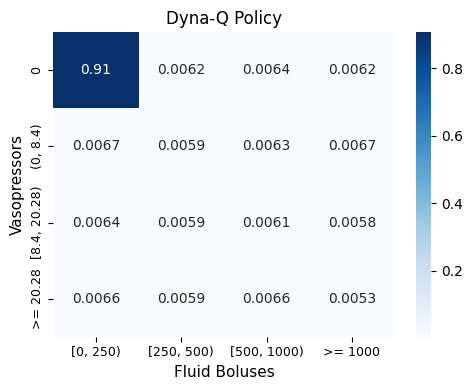

<Figure size 640x480 with 0 Axes>

In [25]:
#plot action heatmap
#dynaq_actions = [0,1,4,2,5,3,15]
action_count_matrix = np.zeros((4, 4))
for i in range(len(dynaq_fluids)):
    fluid = dynaq_fluids[i]
    vaso = dynaq_vasopressors[i]
    action_count_matrix[fluid,vaso] += 1
action_distribution_dynaq = action_count_matrix / len(dynaq_fluids)
#fluid_categories = ['0', '250', '500', '1000']
#vasopressor_categories = ['0', '1e-6', '8.4', '20.28']
fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
plt.figure(figsize=(5, 4))
sns.heatmap(action_distribution_dynaq, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories)
plt.title('Dyna-Q Policy')
plt.xlabel('Fluid Boluses', fontsize=11)
plt.ylabel('Vasopressors', fontsize=11)
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()
plt.savefig('heatmap.png')

In [49]:
print(action_distribution_dynaq)

[[0.90681286 0.00620341 0.00642107 0.00620341]
 [0.00674756 0.00590412 0.00625782 0.00669315]
 [0.00639386 0.00590412 0.00614899 0.00579529]
 [0.00661153 0.00593133 0.00663873 0.00533275]]


In [ ]:
#plot Q value over time series (not run yet)
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "dist_dqn"])
q_values_dist

plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="se")
sns.lineplot(x="hour", y="dist_dqn", data=q_values_dist, errorbar="se")
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
# plt.ylim([-3, 1.0])
plt.legend(["Clinician", "Clinician SD", "Distributional DQN", "Distributional DQN SD"], loc="lower right")
plt.show()